In [ ]:
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import re
import time
import unicodedata

import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

2654208/2638744 [==============================] - 0s 0us/step


In [ ]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

### Preprocessing

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)

def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [ ]:
# Pick 30k sample
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)


Maximum length of the input sentence is 16 tokens, output sentense is 11 tokens.

In [ ]:
input_tensor_train.shape, input_tensor_val.shape, target_tensor_train.shape, target_tensor_val.shape

((24000, 16), (6000, 16), (24000, 11), (6000, 11))

Each sentence transformed into a list of integers. Each element (int) denotes a token in the sentence.

In [ ]:
input_tensor_train

array([[   1,   83,   11, ...,    0,    0,    0],
       [   1,    6, 1410, ...,    0,    0,    0],
       [   1,   23,  670, ...,    0,    0,    0],
       ...,
       [   1,  542, 1934, ...,    0,    0,    0],
       [   1,    6,  580, ...,    0,    0,    0],
       [   1,    4,  261, ...,    0,    0,    0]], dtype=int32)

First sentence. <start> token encoded as 1, <end> token encoded as 2. Zeros are paddings at vacant token places.

In [ ]:
input_tensor_train[0]

array([   1,   83,   11, 1041,    3,    2,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d ----> %s" % (t, lang.index_word[t]))
      
convert(inp_lang, input_tensor_train[0])

1 ----> <start>
83 ----> tienes
11 ----> que
1041 ----> regresar
3 ----> .
2 ----> <end>


First 10 tokens in the vocabulary.

In [ ]:
list(inp_lang.word_index.items())[:10]

[('<start>', 1),
 ('<end>', 2),
 ('.', 3),
 ('tom', 4),
 ('?', 5),
 ('¿', 6),
 ('es', 7),
 ('no', 8),
 ('el', 9),
 ('a', 10)]

Last 10 tokens in the vocabulary

In [ ]:
list(inp_lang.word_index.items())[-8:]

[('caminamos', 9406),
 ('divertir', 9407),
 ('divertiremos', 9408),
 ('divertirnos', 9409),
 ('decepcionaremos', 9410),
 ('viviremos', 9411),
 ('reyes', 9412),
 ('perderemos', 9413)]

To be able to process sentences by neural network , need to encode sentences.

In [ ]:
sentence = preprocess_sentence('Todo sobre mi madre.')
inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
print(inputs)

[1, 74, 514, 19, 237, 3, 2]


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

''' Compress the 9414 dimensional input vectors into 256 dimensional vectors. '''
embedding_dim = 256
''' The dimension of the hidden state/vector. '''
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1 # 9414 
vocab_tar_size = len(targ_lang.word_index)+1 # 4935 

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In this implementation, during training the 'Encoder' class gets a (64, 16) tensor as an input, and it gives out a (64, 16, 1024) tensor as an output, regrdless of how many words the inputs have. That means the class gets the whole sentence as a sequence of integers, and gives out a 1024-dim vector every times step, I mean each token. 

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz # 64 
    self.enc_units = enc_units  # 24000 // 64 = 375 
    
    '''
      As I explained in the last article, you propagate input 9414 dimensional vectors to 256 embedding vectors. 
    '''
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # (9414, 256)
    
    '''
    We use a RNN model named GRU for this seq2seq translation model. 
    All you have to keep in mind is, in this implentation, at time step t, one GRU cell takes 'embedding_dim'(=256) 
    dimensional vector as an input, and gives out a 16 dimensional (the maximum size of input sentences) output vector 
    and succeeds a hidden state/vector to the next GRU cell.  
    '''
    
    self.gru = tf.keras.layers.GRU(self.enc_units, # 1024 *the dimension of the hidden vector/state. 
                                   return_sequences=True, 
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    
    '''
     tf.keras.layers.GRU class gets [batch, timesteps, feature] sized tensors as inputs. 
     https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
    '''
    output, state = self.gru(x, initial_state = hidden)
    return output, state


  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


'''
  You construct an 'Encoder' calss as below. 
  One cell get a 9414 dimensional one-hot vector, and i
'''
encoder = Encoder(vocab_inp_size, # 9414 
                  embedding_dim, # 256 
                  units, # 1024 
                  BATCH_SIZE # 24000 
                 )


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    '''
      In the decoder part, you get an embedding vector for an input token every time step. 
      You have to calculate attentions using this class at EVERY TIME STEP. 
      'query' is the hidden state of an RNN cell at the time in the decoder part, whose size is (batch_size, 1, 1024).
      'values' is the outputs of the encoder part, whose size is (batch_size, 16, 1024). 
      (*The length of the input is not necessarily 16.)
      
      Attention mehcanism calculates relevances of a query and values with a certain function. 
      There are several functions for calculating the relevances, and in this implementation 
      we use Bahdanau"s additive style. 
    '''
    
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    
    '''
      In this implementation, you always need to consider time steps. 
    '''
    query_with_time_axis = tf.expand_dims(query, 1)

    '''
      You get the attentions between the query and outputs of the encoder below.
      In short, you compare the a word in the decoder with the input. 
      This is equivalent to finding the corresponding words in the original language, 
      when you are going to write a word in the target language. 
    '''
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    '''
      You normalize the score calculated above with a softmax function so that the usm of its values is 1. 
    '''
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    '''
      You reweight the outputs of the encoder with attention scores.
      The shape of the resulitng 'context_vector' is (64, 16, 1024)
    '''
    context_vector = attention_weights * values 
    '''
      You calculate the weighted average of the reweighted vectors above. 
      Thus the size of the shape of the resulting 'context_vector' is (64, 1024). 
    '''
    context_vector = tf.reduce_sum(context_vector, axis=1) # You take a weighted average of c

    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    '''
     As well as 'Encoder' class, the shape of inputs of 'Decoder' is [batch, timesteps, feature]. 
     https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
     But you have to keep it in mind that you input a token every time step, the input is 
     (batch_size, 1, embedding_dim). 
    '''
    
    '''
     You first calculate a 'context_vector' by comparing the hidden layer of the LAST cell, 
     with the outputs of the encoder because you use Bahdanau's additive style attention mechanism. 
     You usually use the hidden layer of the current cell.
     
    '''
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    '''
     You combine the 'context_vector' with the embedding vector of the decoder input at this time step. 
     And the RNN cell at current time step gives out a predicted word, given the combined input. 
    '''
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    
    # output shape == (batch_size, vocab)
    x = self.fc(output)
    '''
      x: a vector whose dimension is the size of the output vocabulary size. The index of the maximum
         element of this vector is the index of the predicted word at this time step. 
      state: the hidden state at this time step. This is the query of the next time step in Bahdanau's 
             additive style. 
    '''
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
#@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  '''
    You input a (batch size, max input length) (=(64, 16)) tensor as an input
    and a (batch size, max output length) (=(64, 11)) as an output, and get a loss. 
  '''
    
  with tf.GradientTape() as tape:
    '''    
      You put a batch of input sentences as a (64, 16) tensor. 
    '''
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    '''
      You pass the last hidden state/vector of the encoder to the decoder as its 
      inittial layer.
    '''
    
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    
    '''
    In the encoder part you pass the whole sentence as an input, 
    whereas in the decoder part, you pass a word every time step in the loop below.  
    '''
    
    '''
      The loop below shows that you 
    '''
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, 
                                           dec_hidden, 
                                           enc_output) # You need encoder outputs to calculate attentions. 

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  '''
  Updating the weigths with the three lines below.   
  '''
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  '''
   You initialize the 'unit' dimensional hidden layer (1024 dimensional) as a 'unit' dimensional zero vector. 
  '''
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    '''
     You input a (batch size, max input length) (=(64, 16)) matrix as an input
     and a (batch size, max output length) (=(64, 11)) as an output, and get a loss. 
     'enc_hidden' is the last 'units' dimensional hidden state vector (1024 dimensional) of the encoder. 
    '''
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.5063
Epoch 1 Batch 100 Loss 2.1224
Epoch 1 Batch 200 Loss 1.7876
Epoch 1 Batch 300 Loss 1.6997
Epoch 1 Loss 2.0316
Time taken for 1 epoch 119.84375071525574 sec

Epoch 2 Batch 0 Loss 1.6021
Epoch 2 Batch 100 Loss 1.3998
Epoch 2 Batch 200 Loss 1.2826
Epoch 2 Batch 300 Loss 1.2212
Epoch 2 Loss 1.3813
Time taken for 1 epoch 104.93744564056396 sec

Epoch 3 Batch 0 Loss 1.0259
Epoch 3 Batch 100 Loss 1.0805
Epoch 3 Batch 200 Loss 0.9038
Epoch 3 Batch 300 Loss 0.8294
Epoch 3 Loss 0.9576
Time taken for 1 epoch 103.60822772979736 sec

Epoch 4 Batch 0 Loss 0.5659
Epoch 4 Batch 100 Loss 0.6945
Epoch 4 Batch 200 Loss 0.7058
Epoch 4 Batch 300 Loss 0.5952
Epoch 4 Loss 0.6519
Time taken for 1 epoch 103.36160707473755 sec

Epoch 5 Batch 0 Loss 0.4489
Epoch 5 Batch 100 Loss 0.3336
Epoch 5 Batch 200 Loss 0.4785
Epoch 5 Batch 300 Loss 0.4565
Epoch 5 Loss 0.4431
Time taken for 1 epoch 101.60948491096497 sec

Epoch 6 Batch 0 Loss 0.2772
Epoch 6 Batch 100 Loss 0.2831
Epoch 6 Batch 200

In [ ]:
def evaluate(sentence):
  '''
    Preparing an array to display attention scores. 
  '''
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  '''
    Preparing inputs and outputs. 
  '''
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  '''
    Initializing the hidden state of the encoder and getting outputs 
    the encoder.
  '''
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    
    
    '''
      You get a 'prediction' at every time step in the decoder part. 
      The index of the maximum element is the index of the predicted word. 
    '''
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '
    
    '''
      When the decoder generate the token '<end>', RNNs stop decoding. 
    '''
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  '''
    You delete unnecessary attention scores below, and display the reduced attention scores. 
  '''
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring checkpoint_dir 
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


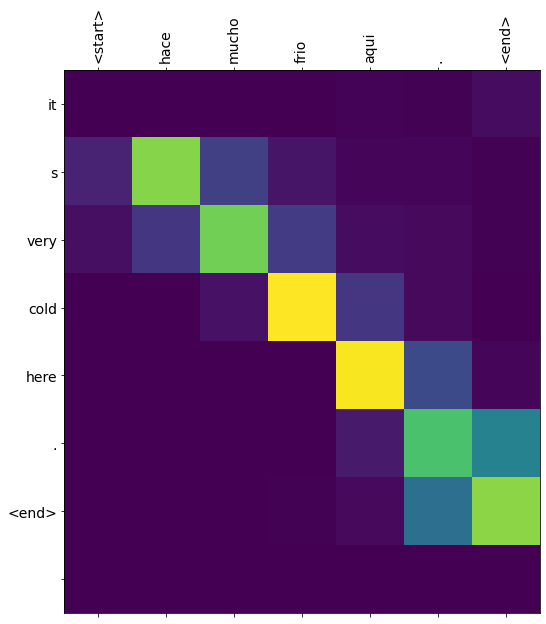

In [33]:
translate(u'hace mucho frio aqui.')